# OLS Estimation with Bootstrap Sampling SIR Model
Author: Ariel Cintron-Arias, Ph.D.

### R Libraries

If needed use the following command to install R-packages 

`install.packages(  )`



In [1]:
#install.packages('deSolve')
#install.packages('GA')
#install.packages('parallel')
#install.packages('doParallel')
#install.packages('outbreaks')

In [2]:
library(graphics)
library(deSolve)
library(GA)
library(outbreaks)

Loading required package: foreach

Loading required package: iterators

Package 'GA' version 3.2.4
Type 'citation("GA")' for citing this R package in publications.


Attaching package: ‘GA’


The following object is masked from ‘package:utils’:

    de




### Mathematical Model

In [3]:
### Mathematical model 
sir.single.outbreak = function(t,x,model.parameters){
  beta = model.parameters[1]
  gamma = model.parameters[2]
  N = x[1] + x[2] + x[3]
  eqns = vector(mode="numeric",length = length(x))
  eqns[1] = -beta*x[1]*x[2]/N
  eqns[2] = beta*x[1]*x[2]/N - gamma*x[2]
  eqns[3] = gamma*x[2]
  return(list(eqns))
}

### Single-Outbreak Dataset

The R-library `outbreaks` contains a data frame called 'influenza_england_1978_school' with three columns. See documentation: https://cran.r-project.org/web/packages/outbreaks/index.html

In [4]:
library(outbreaks)

str(influenza_england_1978_school)

'data.frame':	14 obs. of  3 variables:
 $ date        : Date, format: "1978-01-22" "1978-01-23" ...
 $ in_bed      : int  3 8 26 76 225 298 258 233 189 128 ...
 $ convalescent: int  0 0 0 0 9 17 105 162 176 166 ...


We will use the second column as head counts of infectives, with assumed daily time steps of size one.

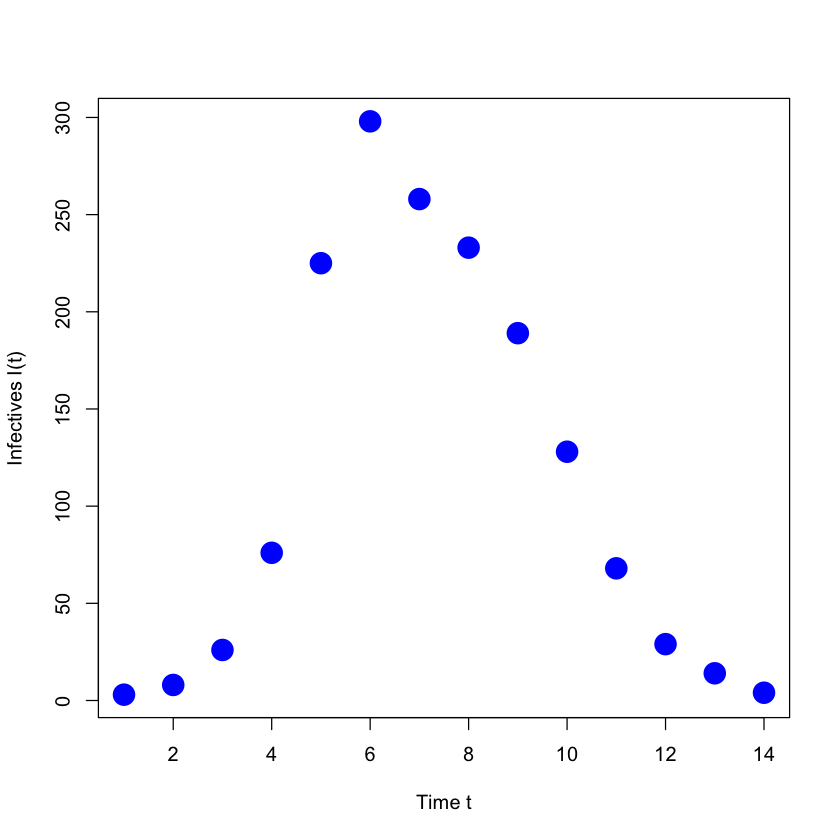

In [5]:
tvals = seq(1,dim(influenza_england_1978_school)[1],by=1)
xvals = influenza_england_1978_school[,2]
xvals1 = xvals
### Initial conditions
x0.vec = c(763-xvals[1],xvals[1],0) 
### Scatter plot
matplot(tvals,xvals,col="blue",pch=16,cex=2.5, xlab="Time t",ylab="Infectives I(t)")

### OLS Estimation of Model Parameters

In [6]:
### Sum of squares
fit.ols.sir = function(theta){
  time.grid.fine = seq(tvals[1],tvals[length(tvals)],by=1e-2)
  out = lsoda(y=x0.vec,times=time.grid.fine,func=sir.single.outbreak,parms=theta);
  if(sum(is.nan(out)) || length(out[,2]) < length(time.grid.fine)){
    sum.squared.residuals = 1e+100
  }else{
    f.model = approx(time.grid.fine,out[,3],tvals)$y
    sum.squared.residuals = sum((f.model - xvals)^2)
  }
  return(sum.squared.residuals)
}

### Optimization: minimizing sum of square residuals with GA
lower.bounds = c(0.5,0.1) ## adjust while applying prior knowledge or initial guess
upper.bounds = c(5,1.5) ## calibrate using initial guess

fit.sir.ga = ga(type = "real-valued",
                fitness = function(q)-fit.ols.sir(q),
                maxiter = 100, ## increase accordingly
                lower = lower.bounds,
                upper = upper.bounds,
                #suggestions = c(1,0.95),## may be used to include guess in initial population
                popSize = 5e+2,## adjust depending on number of parameters being estimated
                parallel = TRUE)

parameter.estimates0 <- fit.sir.ga@solution

### Standard Residuals

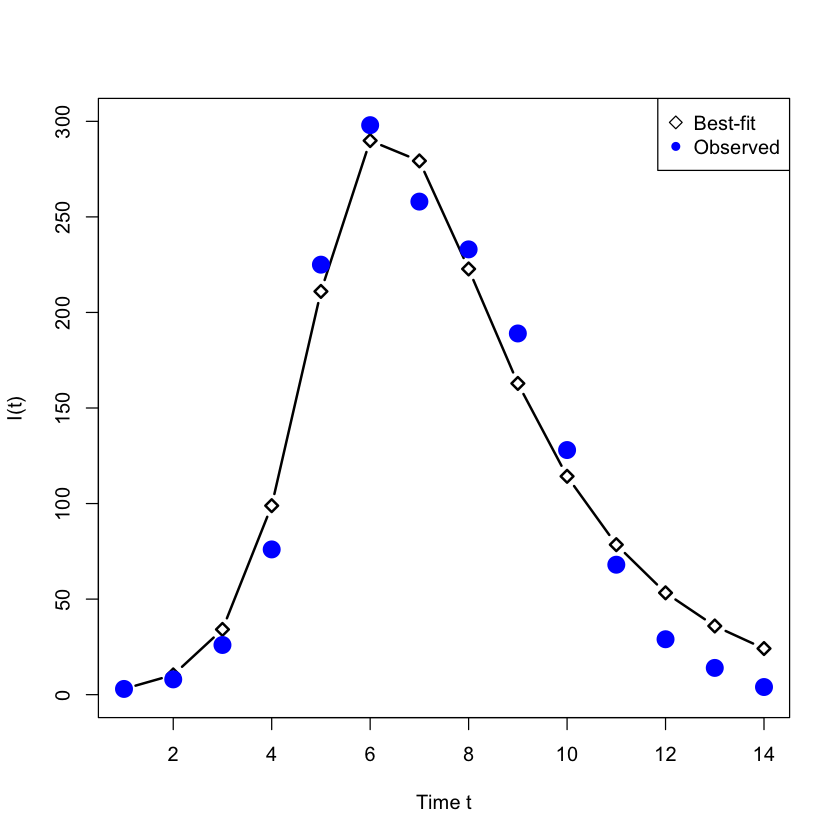

In [7]:
bestfit.solution = lsoda(y = x0.vec,times = tvals,
                         func = sir.single.outbreak,parms = parameter.estimates0)
prevalence = bestfit.solution[,3]
scaling.fac =  sqrt(length(xvals)/(length(xvals)-length(parameter.estimates0)))
std.res = scaling.fac*(xvals - prevalence)

matplot(tvals,prevalence,type="b",col="black",lty=1,lwd=2,pch=5,
        xlab="Time t",ylab="I(t)",ylim=c(0,300))
points(tvals,xvals1,col="blue",pch=16,cex=2)
legend('topright',legend=c('Best-fit','Observed'),col=c('black','blue'),pch=c(5,16))

### Bootstrap Samples Using Simple Random Sampling with Replacement

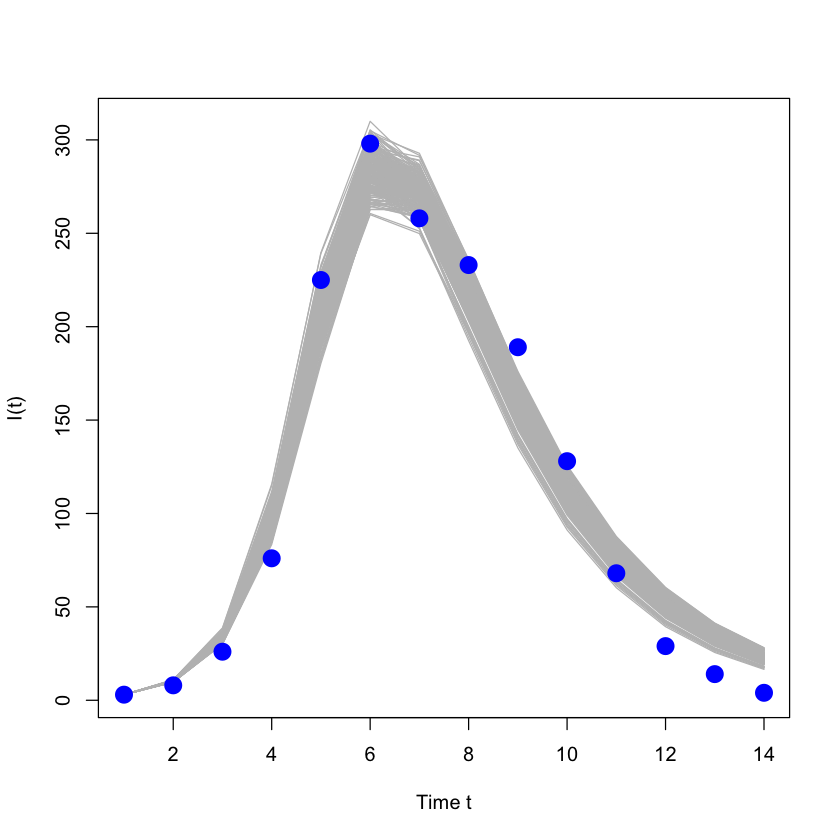

In [12]:
number.bootstrap.samples = 250 ### increase
boostrap.matrix = matrix(nrow = number.bootstrap.samples,ncol = length(parameter.estimates0))
boostrap.samplepoints.matrix = matrix(nrow = length(tvals),ncol = number.bootstrap.samples)
#
default_warning = getOption("warn")
options(warn = -1)
#
for(m in seq(1,number.bootstrap.samples,by=1)){
  xvals = prevalence + sample(std.res,replace = TRUE) ## over-write xvals with bootstrap sample points
  fit.sir.m =optim(par = parameter.estimates0,fn = fit.ols.sir,
                   method = "L-BFGS-B",lower = lower.bounds,upper = upper.bounds)
  boostrap.matrix[m,] = fit.sir.m$par
  bestfit.sol.bootstrap = lsoda(y = x0.vec,times = tvals,func = sir.single.outbreak,parms =  boostrap.matrix[m,])
  boostrap.samplepoints.matrix[,m] = bestfit.sol.bootstrap[,3]
}

matplot(tvals,boostrap.samplepoints.matrix,type="l",col="gray",lty=1,
        xlab="Time t",ylab="I(t)")
points(tvals,xvals1,col="blue",pch=16,cex=2)
options(warn = default_warning)

## Point Estimates

In [9]:
estimates.bootstrap = parameter.estimates0
for(k in 1:dim(boostrap.matrix)[2]){
  estimates.bootstrap[k] = mean(boostrap.matrix[,k])
}
estimates.bootstrap

x1,x2
1.70224,0.4584046


## Standard Errors

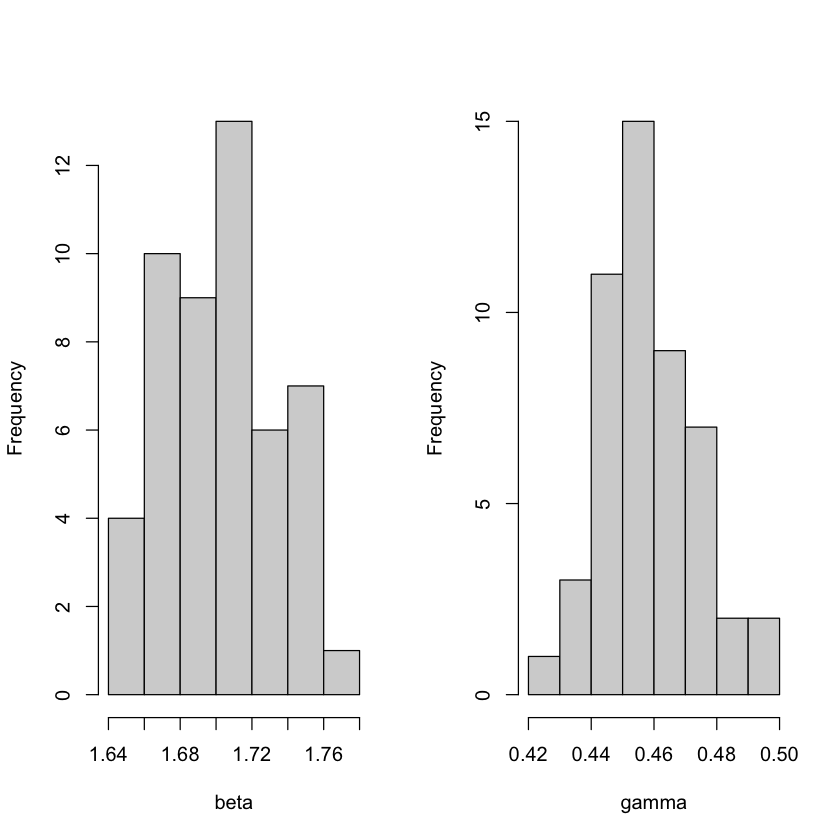

In [10]:
par(mfrow=c(1,2))
hist(boostrap.matrix[,1],main="",xlab = "beta")
hist(boostrap.matrix[,2],main="",xlab="gamma")

In [11]:
c.matrix = cov(boostrap.matrix)
sqrt(diag(c.matrix))

[1] 0.03095102 0.01475763